## 10. Test A/B


En el presente notebook se desarrollara un experimento A/B. Los registros utilizados pertenecen a un conjunto de datos de Kaggle que contiene los resultados de una prueba A/B. Se asume que los datos se tratan de dos diseños diferentes de una página de sitio web, identitificados como: old_page y new_page.

Link pagina Kaggle: https://www.kaggle.com/datasets/zhangluyuan/ab-testing

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline
np.random.seed(42)

In [2]:
path = r"ab_data.csv"
df = pd.read_csv(path)
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


b. Se depuran a los usuarios repetidos

In [4]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users   = session_counts[session_counts > 1].count()
users_to_drop = session_counts[session_counts > 1].index
df = df[~df['user_id'].isin(users_to_drop)]
print(f'El dataset ahora tiene {df.shape[0]} entradas')

El dataset ahora tiene 286690 entradas


In [5]:
# Muestra del dataset
required_n = 5000
control_sample = df[df['group']=='control'].sample(n=required_n,
                                                   random_state=22)

treatment_sample = df[df['group']=='treatment'].sample(n=required_n,
                                                   random_state=22)


ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9995,787786,2017-01-06 18:10:45.577881,treatment,new_page,0
9996,770196,2017-01-24 07:07:24.954319,treatment,new_page,0
9997,775724,2017-01-18 10:54:36.300523,treatment,new_page,0
9998,920254,2017-01-23 00:40:30.728885,treatment,new_page,0


In [6]:
ab_test['group'].value_counts()

control      5000
treatment    5000
Name: group, dtype: int64

In [7]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=1)
se_p  = lambda x: stats.sem(x, ddof=1)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])

conversion_rates.columns=['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.127,0.333,0.005


Text(0, 0.5, 'probability')

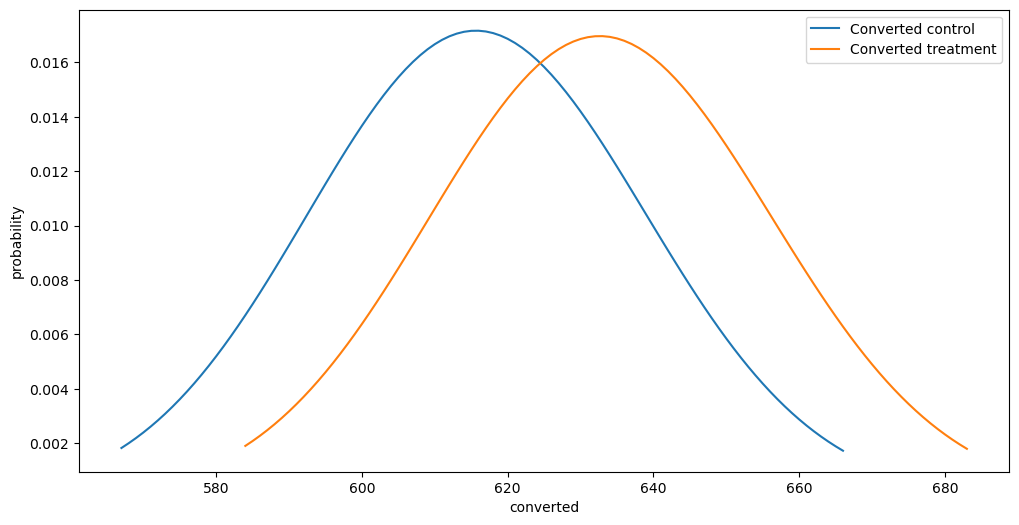

In [8]:
A_group = ab_test[ab_test['group'] == 'control']
B_group = ab_test[ab_test['group'] == 'treatment']


A_converted, B_converted = A_group['converted'].sum(), B_group['converted'].sum()
A_converted, B_converted


A_total, B_total = len(A_group), len(B_group)
A_total, B_total

p_A, p_B = A_converted / A_total, B_converted / B_total

fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = stats.binom(A_total, p_A).pmf(xA)
ax.plot(xA, yA, label='Converted control')
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = stats.binom(B_total, p_B).pmf(xB)
ax.plot(xB, yB, label='Converted treatment')

ax.legend()
plt.xlabel('converted')
plt.ylabel('probability')

In [9]:
from statsmodels.stats.proportion import proportions_ztest,proportion_confint
control_results = ab_test[ab_test['group']=='control']['converted']


treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()

n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)

(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)


print(f'z_statistic: {z_stat:0.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f},{upper_con:.3f}]')
print(f'ci 95% for control group: [{lower_treat:.3f},{upper_treat:.3f}]')      
      

z_statistic: -0.51
p-value: 0.607
ci 95% for control group: [0.114,0.132]
ci 95% for control group: [0.117,0.136]


### D10. Discusión de resultados
Dado que el valor de p=0,607, siendo mayor que el umbral de significancia α=0,05, no se rechaza la hipótesis nula Hₒ, lo que significa que el diseño de la nueva pagina no muestra diferencias significativas respecto a la versión antigua de la página (y mucho menos mejor).